In [ ]:
!pip install rpy2

In [49]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [51]:
# Load necessary R packages
base = importr('base')
DESeq2 = importr('DESeq2')

In [52]:
Counts = pd.read_csv('HCC364_timecourse.csv', index_col=0)
Counts.head()

,DMSO_1,DMSO_2,250D_1,250D_2,30D_1,30D_2,40D_1,40D_2,50D_1,50D_2
Gene,,,,,,,,,,
A1BG,0.13,0.08,0.43,0.68,0.42,0.54,0.26,0.10,0.24,0.51
A1BG.AS1,0.00,0.00,0.00,0.11,0.23,0.13,0.37,0.14,0.17,0.29
A1CF,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00
A2M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00
A2M.AS1,0.26,0.15,0.17,0.47,0.66,1.03,0.28,0.61,0.59,0.42


In [53]:
# Convert counts to integers
Counts = Counts.astype(int)

In [54]:
#coldata
# Define the condition factor
condition = ['C', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']

# Define colData as a pandas DataFrame
colData = pd.DataFrame({'condition': condition}, index=Counts.columns)

In [55]:
# Convert pandas DataFrames to R data frames
with localconverter(robjects.default_converter + pandas2ri.converter):
    Counts_r = robjects.conversion.py2rpy(Counts)

with localconverter(robjects.default_converter + pandas2ri.converter):
    colData_r = robjects.conversion.py2rpy(colData)

condition_r = robjects.FactorVector(condition)

c:\Users\aubhi\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [56]:
design_formula = robjects.Formula('~ condition')

In [ ]:
# Convert pandas DataFrames to R data frames: Alternative versions
#Counts_r = pandas2ri.py2ri(Counts)
#colData_r = pandas2ri.py2ri(colData)
#condition_r = robjects.FactorVector(condition)

In [57]:
dds = DESeq2.DESeqDataSetFromMatrix(
    countData=Counts_r,
    colData=colData_r,
    design=design_formula
)

In [62]:
from rpy2.robjects import r

dds = r('estimateSizeFactors')(dds)
dds = r('estimateDispersions')(dds)


R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



In [96]:
# Run the DESeq function
dds = DESeq2.DESeq(dds)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [97]:
# Extract results
results = DESeq2.results(dds)

In [98]:
results

<rpy2.robjects.methods.RS4 object at 0x000002616F3873C0> [RTYPES.S4SXP]
R classes: ('DESeqResults',)

In [102]:
# Ensure that the automatic conversion is active
pandas2ri.activate()

# Extract the data frame from the results
results_df_r = robjects.r['as.data.frame'](results)

# Convert to a pandas DataFrame
with localconverter(robjects.default_converter + pandas2ri.converter):
    results_df = robjects.conversion.rpy2py(results_df_r)


# Deactivate the automatic conversion (optional, but good practice)
pandas2ri.deactivate()

In [103]:
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,0.000000,NaN,NaN,NaN,NaN,NaN
2,0.000000,NaN,NaN,NaN,NaN,NaN
3,0.000000,NaN,NaN,NaN,NaN,NaN
4,0.000000,NaN,NaN,NaN,NaN,NaN
5,0.091066,0.353334,3.950882,0.089432,0.928739,NaN
...,...,...,...,...,...,...
26330,0.716013,-0.672246,1.588940,-0.423078,0.672238,NaN
26331,8.459134,0.457371,0.517547,0.883728,0.376843,0.706298
26332,126.764257,0.989394,0.334800,2.955181,0.003125,0.034993
26333,5.375254,0.735465,0.677892,1.084930,0.277953,0.613544


Volcano plot

In [104]:
# Calculate -log10 P-values
results_df['minus_log10_pvalue'] = -np.log10(results_df['pvalue'])

In [105]:
# Set thresholds for significance
pvalue_threshold = 0.05
fold_change_threshold = 1  # log2 fold change

In [106]:
# Create a new column to mark the significant points
results_df['significant'] = (results_df['pvalue'] < pvalue_threshold) & (abs(results_df['log2FoldChange']) > fold_change_threshold)

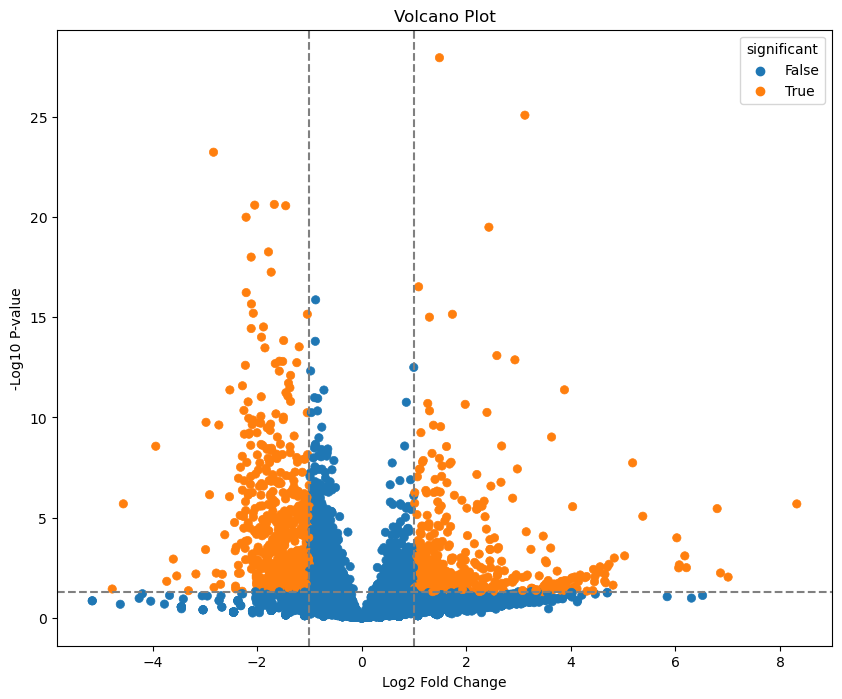

In [107]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df, hue='significant', edgecolor=None)

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()

In [114]:
results_df.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'minus_log10_pvalue', 'significant'],
      dtype='object')

In [111]:
results_df_2 = results_df.copy()

In [112]:
results_df_2['gene'] = Counts.index
results_df_2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,minus_log10_pvalue,significant,gene
1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,A1BG
2,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,A1BG.AS1
3,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,A1CF
4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,A2M
5,0.091066,0.353334,3.950882,0.089432,0.928739,NaN,0.032106,False,A2M.AS1


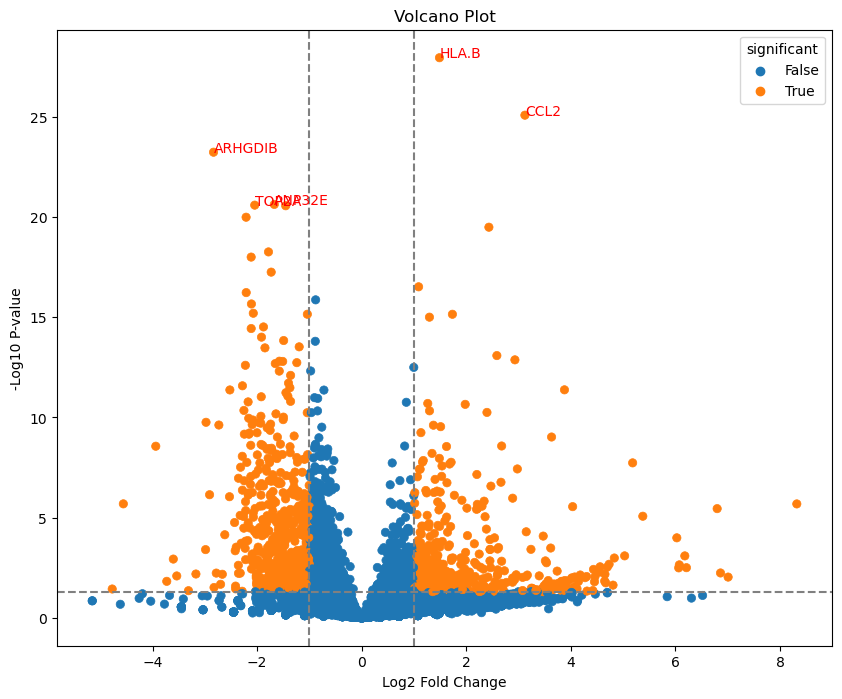

In [115]:
top_genes = results_df_2.nsmallest(5, 'pvalue')

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Annotate top genes
for _, row in top_genes.iterrows():
    plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene'], color='red')

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()

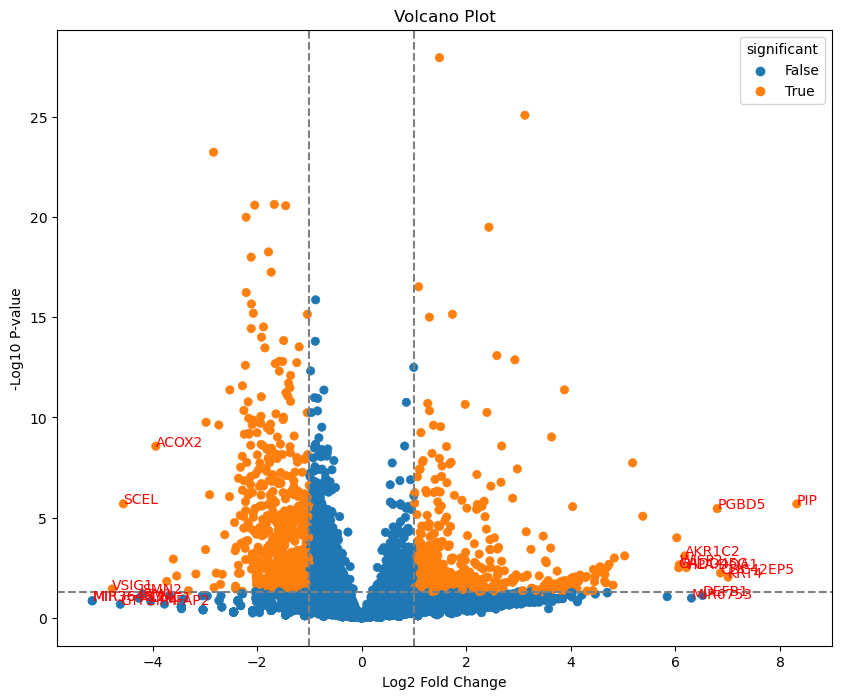

In [124]:
# Number of top genes to select from each category (upregulated and downregulated)
top_n = 10

# Select the top upregulated genes
top_upregulated = results_df_2.nlargest(top_n, 'log2FoldChange')

# Select the top downregulated genes
top_downregulated = results_df_2.nsmallest(top_n, 'log2FoldChange')

# Combine the two sets of genes
top_genes_2 = pd.concat([top_upregulated, top_downregulated])

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Annotate top genes
for _, row in top_genes_2.iterrows():
    plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene'], color='red')  # Replace 'gene' with actual column name

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()


Gese set enrichment

In [139]:
# Number of top genes to select from each category (upregulated and downregulated)
top_n_gsea = 100

# Select the top upregulated genes
top_upregulated_GSEA = results_df_2.nlargest(top_n_gsea, 'log2FoldChange')

# Select the top downregulated genes
top_downregulated_GSEA = results_df_2.nsmallest(top_n_gsea, 'log2FoldChange')

# Combine the two sets of genes
top_genes_GSEA = pd.concat([top_upregulated_GSEA, top_downregulated_GSEA])

c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self

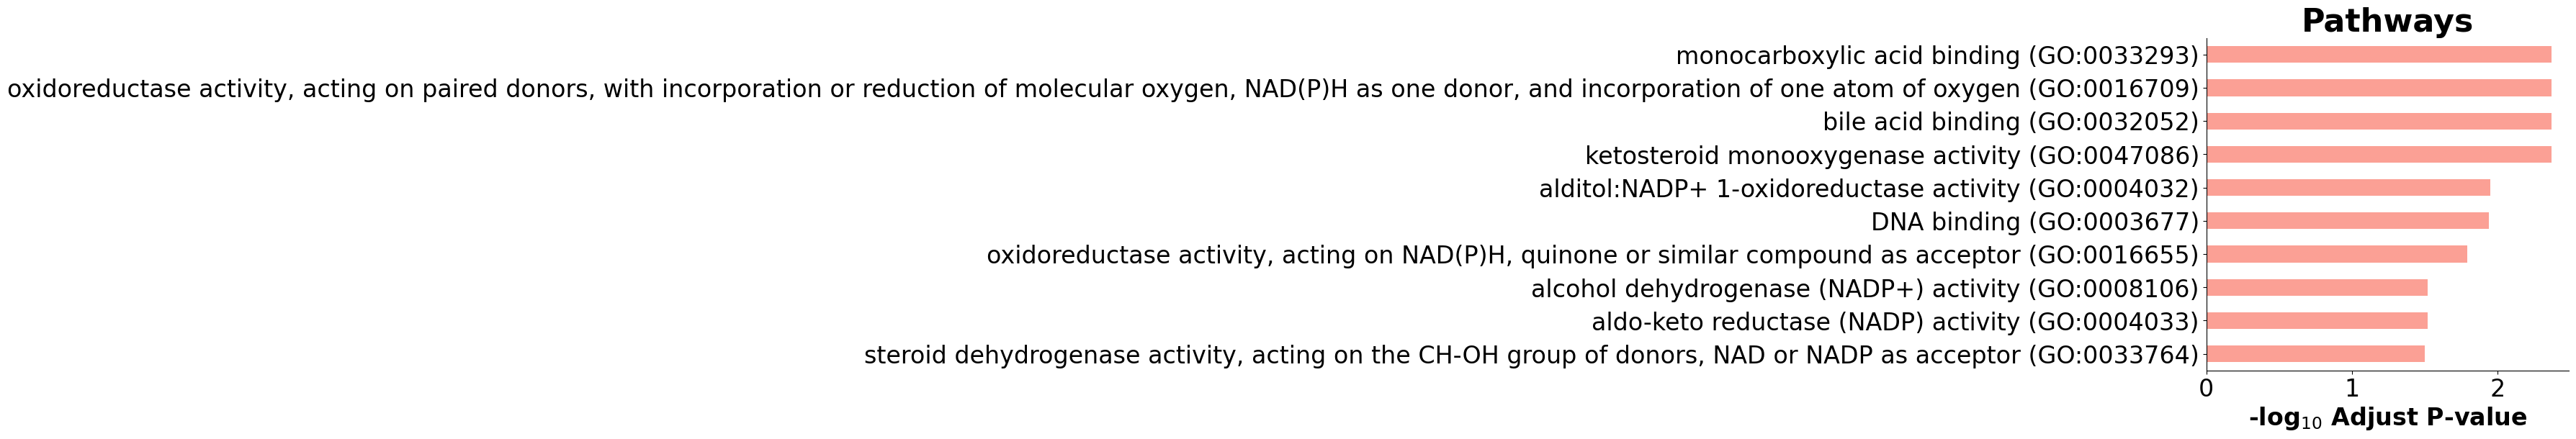

In [140]:
# GSEAPY on top_genes_GSEA
import gseapy as gp
from gseapy.plot import barplot, dotplot

# Create a list of gene names
gene_list = list(top_genes_GSEA['gene'])

# Run GSEA
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=['KEGG_2019_Human', 'Reactome_2016', 'BioPlanet_2019', 'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'], # 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X', 'ENCODE_Histone_Modifications_2015', 'ENCODE_TF_ChIP-seq_2015'
    description='test_name',
    outdir='test/enrichr_kegg',
    cutoff=0.5  # only get pathways with p-value < 0.05
)

# Plot the results
barplot(enr.res2d, title='Pathways')

Network analyses

In [141]:
# Netowrk plot of the top_gene_GSEA gene_list
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create a networkx graph object
G = nx.Graph()

for gene in gene_list:
    G.add_node(gene)

# Add edges
#G.add_edge('Gene1', 'Gene2')

# Visualize the network
#nx.draw(G, with_labels=True)
#plt.show()

In [134]:
import requests

In [142]:
# Construct the query for the STRING API
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "/interaction_partners"
params = {
    "identifiers": "%0d".join(gene_list),  # Your list of genes
    "species": 9606,  # Human (Homo sapiens)
    "limit": 10,  # Limit the number of interactions (adjust as needed)
    "network_flavor": "confidence"  # Type of network
}

# Send the request to STRING
response = requests.post(f"{string_api_url}/{output_format}/{method}", data=params)

# Check if the request was successful
if response.status_code == 200:
    interactions = response.json()
    for interaction in interactions:
        # Extract interacting genes
        gene_a = interaction["preferredName_A"]
        gene_b = interaction["preferredName_B"]
        # Add edge if both genes are in your list
        if gene_a in gene_list and gene_b in gene_list:
            G.add_edge(gene_a, gene_b)
else:
    print("Failed to retrieve data")


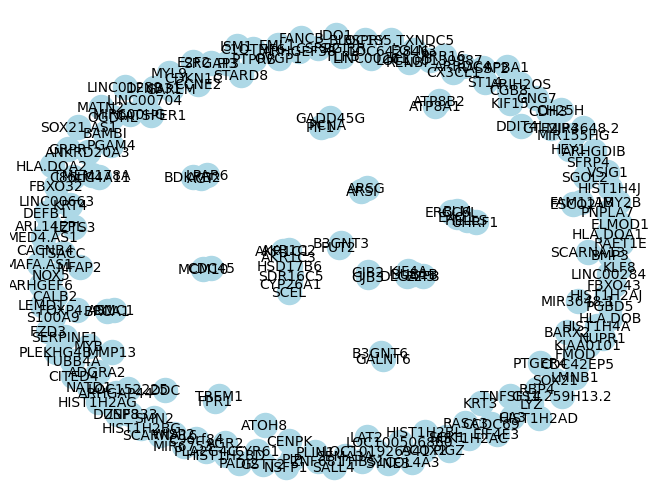

In [143]:
# Draw the network
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()

Checking interaction with known data

Interactions found: 300
TP53 SFN
TP53 EP300
TP53 HIF1A
TP53 HDAC1
TP53 HSP90AA1
TP53 ATM
TP53 MDM4
TP53 CHEK2
TP53 BCL2
TP53 BCL2L1
TP53 PPP1R13L
TP53 DAXX
TP53 SIRT1
TP53 BRCA1
TP53 CDKN1A
TP53 TP53BP2
TP53 UBE3A
TP53 USP7
TP53 CREBBP
TP53 MDM2
TP53 RPA1
TP53 CDKN2A
TP53 TP53BP1
TP53 PTEN
TP53 HIPK2
TP53 RAD51
TP53 RCHY1
TP53 CREB1
TP53 HTT
TP53 NDN
TP53 AURKA
TP53 MAPK1
TP53 CCNG1
TP53 FOXO3
TP53 HSPA9
TP53 DNMT1
TP53 JUN
TP53 HSPA4
TP53 DDX5
TP53 CHEK1
TP53 PRKDC
TP53 MYC
TP53 NPM1
TP53 MAPK8
TP53 TBP
TP53 CCNA2
TP53 HMGB1
TP53 BAK1
TP53 KAT5
TP53 S100A4
TP53 SUMO1
TP53 ATR
TP53 DROSHA
TP53 HSP90AB1
TP53 BRCA2
TP53 FOXO4
TP53 S100B
TP53 STAT3
TP53 MAPK14
TP53 UBE2I
TP53 BAX
TP53 SP1
TP53 MAPK3
TP53 AKT1
TP53 SMAD2
TP53 PPIF
TP53 SMARCA4
TP53 GSK3B
TP53 ESR1
TP53 SNAI1
TP53 RRM2B
TP53 CASP8
TP53 YWHAZ
TP53 GADD45A
TP53 CDKN1B
TP53 BRD4
TP53 HDAC2
TP53 BRD7
TP53 NFKB1
TP53 SMYD2
TP53 IFI16
TP53 HSPA8
TP53 CDK2
TP53 G6PD
TP53 PPP1R13B
TP53 E2F1
TP53 TP73
TP53 KAT2B
TP53 RB1CC1
TP53 TAF

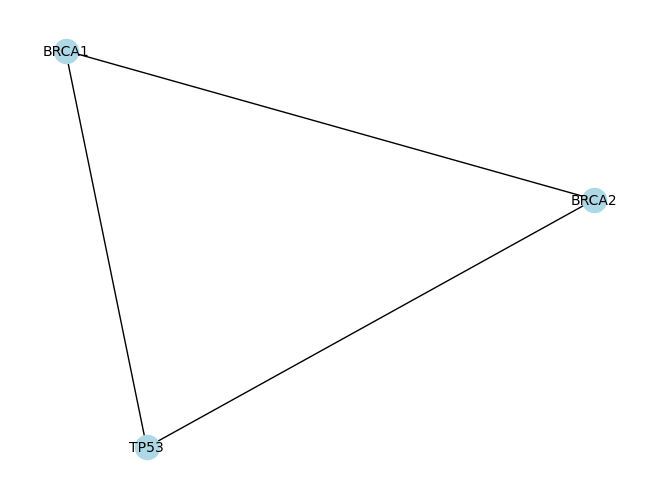

In [144]:
'''# Replace with your actual list of genes
gene_list_known = ['TP53', 'BRCA1', 'BRCA2']  # Example gene list

# Create a network graph
G = nx.Graph()

# Add nodes for each gene
for gene in gene_list_known:
    G.add_node(gene)

# Construct the query for the STRING API
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "/interaction_partners"
params = {
    "identifiers": "%0d".join(gene_list_known),  # Your list of genes
    "species": 9606,  # Human (Homo sapiens)
    "limit": 100,  # Increased limit
    "network_flavor": "confidence"  # Type of network
}

# Send the request to STRING
response = requests.post(f"{string_api_url}/{output_format}/{method}", data=params)

# Check if the request was successful
if response.status_code == 200:
    interactions = response.json()
    print("Interactions found:", len(interactions))  # Debugging line
    for interaction in interactions:
        # Extract interacting genes
        gene_a = interaction["preferredName_A"]
        gene_b = interaction["preferredName_B"]
        print(gene_a, gene_b)  # Debugging line
        # Add edge if both genes are in your list
        if gene_a in gene_list_known and gene_b in gene_list_known:
            G.add_edge(gene_a, gene_b)
else:
    print("Failed to retrieve data")

# Draw the network
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()'''


Repeling th texts

In [122]:
from adjustText import adjust_text

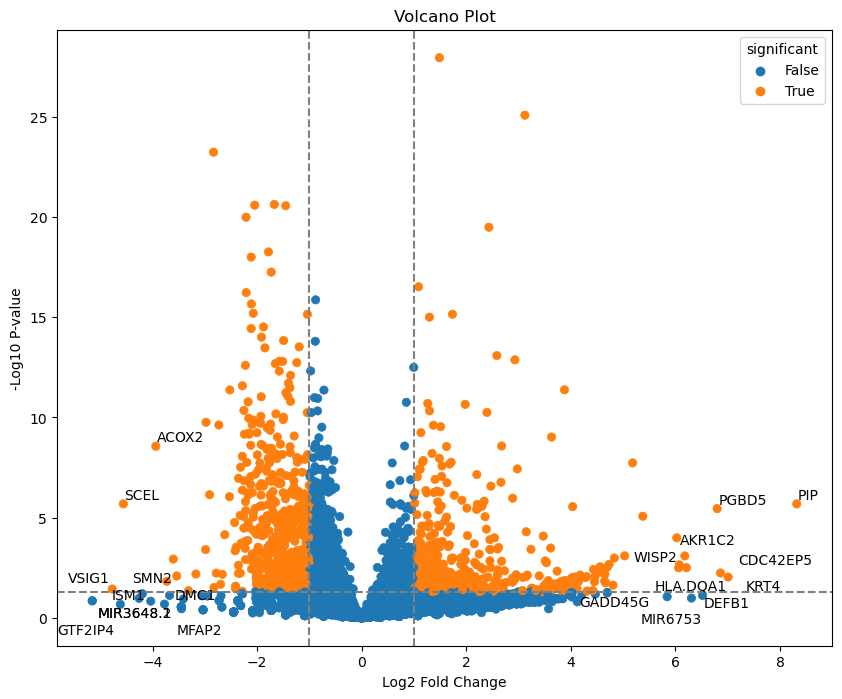

In [125]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Prepare a list to collect the text objects for adjustment
texts = []
for _, row in top_genes_2.iterrows():
    texts.append(plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene']))  # Replace 'gene' with actual column name

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

# Adjust text positions
adjust_text(texts)

plt.show()

In [58]:
dds

<rpy2.robjects.methods.RS4 object at 0x000002615F529600> [RTYPES.S4SXP]
R classes: ('DESeqDataSet',)

PCA analysis

In [64]:
vst = DESeq2.vst(dds, blind=False)
vst_data = r('assay')(vst)

In [77]:
vst_data[0:5, 0:5]

array([[3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119]])

In [69]:
# Perform variance stabilizing transformation
vst = DESeq2.vst(dds, blind=False)

# Extract the transformed data
with localconverter(robjects.default_converter + pandas2ri.converter):
    vst_data = robjects.r['assay'](vst)


In [65]:
from sklearn.decomposition import PCA

In [78]:
colnames

'DMSO_1','DMSO_2','250D_1',...,'40D_2','50D_1','50D_2'


In [80]:
rownames

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000026130ED6100> [RTYPES.NILSXP]

In [82]:
vst_df_2 = pd.DataFrame(vst_data)
vst_df_2.head()

,0,1,2,3,4,5,6,7,8,9
0,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
1,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
2,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
3,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
4,3.112941,3.112941,3.112941,3.112941,3.112941,3.578979,3.112941,3.112941,3.112941,3.112941


In [83]:
vst_df_2.shape

(26334, 10)

In [86]:
vst_df_2.columns = colnames
vst_df_2.head()

,DMSO_1,DMSO_2,250D_1,250D_2,30D_1,30D_2,40D_1,40D_2,50D_1,50D_2
0,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
1,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
2,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
3,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
4,3.112941,3.112941,3.112941,3.112941,3.112941,3.578979,3.112941,3.112941,3.112941,3.112941


In [91]:
# Set the index of vst_df_2 to be the same as the original count data
vst_df_2.index = Counts.index

In [92]:
vst_df_2.head()


,DMSO_1,DMSO_2,250D_1,250D_2,30D_1,30D_2,40D_1,40D_2,50D_1,50D_2
Gene,,,,,,,,,,
A1BG,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
A1BG.AS1,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
A1CF,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
A2M,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941,3.112941
A2M.AS1,3.112941,3.112941,3.112941,3.112941,3.112941,3.578979,3.112941,3.112941,3.112941,3.112941


In [93]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vst_df_2.T)  # Transpose to get samples as rows

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [94]:
import seaborn as sns

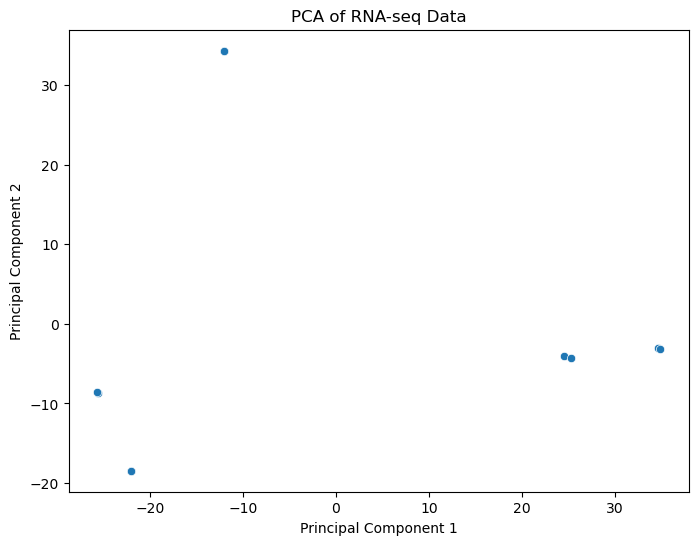

In [95]:
# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA of RNA-seq Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()